# Generating Synthetic Data

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [2]:
df_orl = pd.read_csv("data/parameter_igt_orl.csv")
df_orl["subjID_label"] = df_orl["subjID"].astype("category").cat.codes # number label for old/young
df_orl.head()

,subjID,A+,A-,K,BetaF,BetaP,A+-A-,subjID_label
0,old,0.324444,0.068862,1.502130,2.523191,-5.547480,0.255581,0
1,old,0.885744,0.120145,0.012591,3.193244,-9.159800,0.765598,0
2,old,0.318205,0.078128,1.927309,0.615708,9.272336,0.240077,0
3,old,0.728192,0.106737,0.388407,2.595746,-2.239555,0.621455,0
4,old,0.356229,0.091987,1.810674,0.508605,9.825699,0.264241,0


## Fitting distributions to the parameters

The [Beta($\alpha$,$\beta$) distribution](https://en.wikipedia.org/wiki/Beta_distribution) can be used to model a large variety of distributions.  
It has shape parameters $\alpha$ and $\beta$, and location/scale parameters.  
Details of the functions used to model the distributions can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)

### Modelling a single parameter
Here we show show fitting the beta distribution works for the $\beta_P$ parameter. The plot shows the fitted distribution in orange against the real data in blue.  

In [3]:
a, b, loc, scale = beta.fit(df_orl["BetaP"])
print("alpha:", a)
print("beta:", b)
print("location:", loc)
print("scale:", scale)

alpha: 68.88143534616461
beta: 877.7287713924625
location: -46.975479728775724
scale: 645.7067406640599


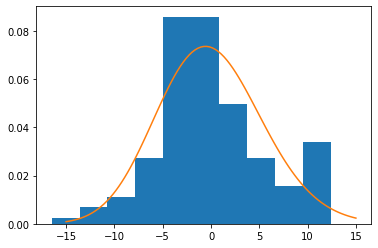

In [4]:
x = np.linspace(-15, 15, 100)
y = beta.pdf(x, a,b,loc=loc,scale=scale)

plt.hist(df_orl["BetaP"], density=True)
plt.plot(x, y)
plt.show()

### Applying to all parameters

First we define a function to fit the beta distribution to a single column.

In [5]:
def fit_beta(s: pd.Series):
    a, b, loc, scale = beta.fit(s)
    return pd.Series({
        "a": a,
        "b": b,
        "loc": loc,
        "scale": scale
        })

fit_beta(df_orl["BetaP"])

a         68.881435
b        877.728771
loc      -46.975480
scale    645.706741
dtype: float64

Then we can apply this across all of our parameters to get model each one. We can see the flexibility of the beta distribution here as it can fit well to each parameter.  

In [6]:
%%capture --no-stdout --no-display

beta_params = df_orl[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params

,A+,A-,K,BetaF,BetaP
a,1.741863e+00,1.277197,1.159286,1.534507e+07,68.881435
b,3.585195e+07,14.350636,2.058774,2.376500e+02,877.728771
loc,3.934748e-02,0.020270,0.010321,-1.091407e+06,-46.975480
scale,4.743963e+06,0.751762,2.299712,1.091425e+06,645.706741


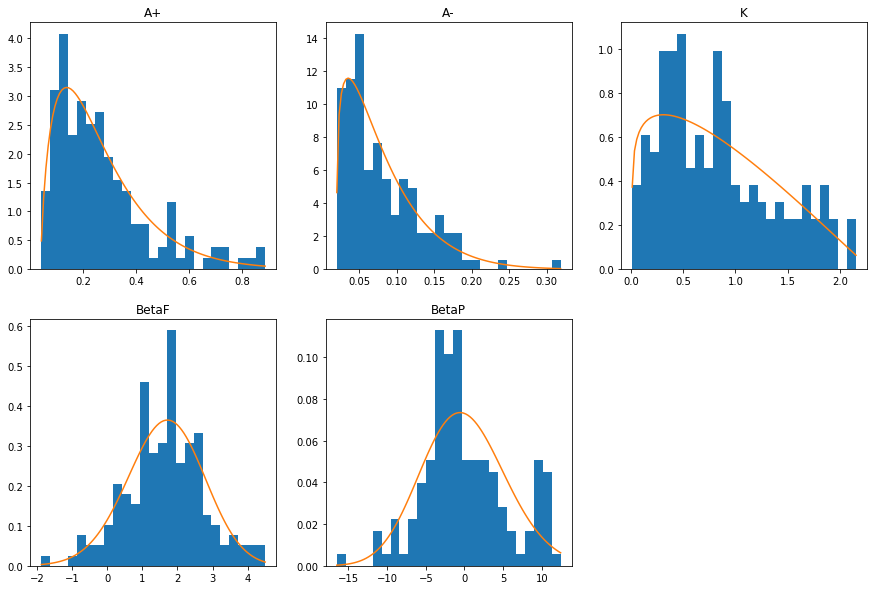

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, param in enumerate(beta_params.columns):
    row, col = divmod(i, 3)
    b_params = beta_params[param]

    # Generate points to draw beta
    x = np.linspace(df_orl[param].min(), df_orl[param].max(), 100)
    y = beta.pdf(x, b_params["a"], b_params["b"], loc=b_params["loc"], scale=b_params["scale"])

    # Draw plots
    ax[row, col].hist(df_orl[param], density=True, bins=25)
    ax[row, col].plot(x, y)
    
    # Formatting
    ax[row, col].set_title(param)
    
# Hide unused plot
ax[1, 2].set_visible(False)

plt.show()

### Generating new data

By modelling these parameters, we can create new data by sampling from their distributions. The generated parameters could then be used to create an ORL model which represents a new person.  
For now we assume that each parameter is independent, though this may not be the case in reality.  
Here we generate 5000 fake data points based on the entire dataset. You can see that the new data is very similar to the real data.

In [8]:
synth_data = pd.DataFrame()
for param in beta_params.columns:
    b_params = beta_params[param]
    sample = beta.rvs(b_params["a"], b_params["b"], loc=b_params["loc"], scale=b_params["scale"], size=5000)
    synth_data[param] = sample
    
synth_data.head()

,A+,A-,K,BetaF,BetaP
0,0.176203,0.039892,1.254919,3.043307,-3.805704
1,0.465209,0.035922,0.520399,4.437186,6.245248
2,0.205180,0.049590,0.553471,1.093211,-0.255820
3,0.160102,0.063360,1.703708,-0.209519,-4.496044
4,0.081312,0.076992,0.442301,-0.754334,-2.519056


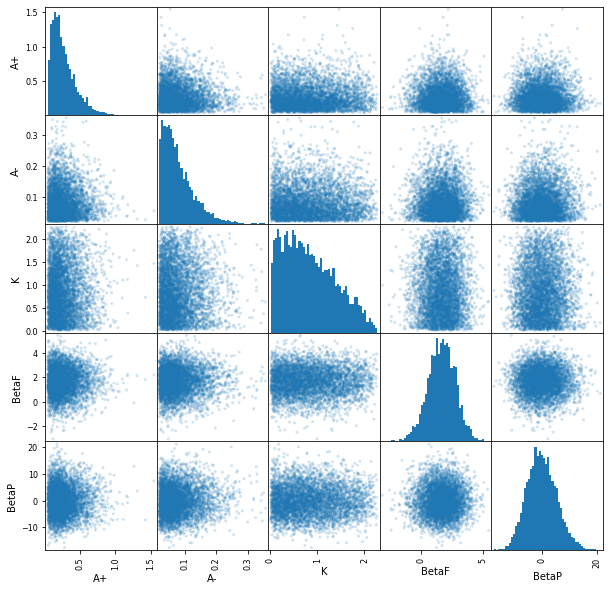

In [9]:
pd.plotting.scatter_matrix(synth_data, figsize=(10,10), hist_kwds=dict(bins=50), alpha=0.2)
plt.show()

### Modelling the smaller groups

As we saw when we explored the data and during clustering, the young and old groups differ quite a bit, and the old group could be clustered into two distinct sets. We can apply the same methods to model each of these groups and generate new data for them. Here we split the old group into "Type A" and "Type B".  

#### Young

In [10]:
%%capture --no-stdout --no-display

df_orl_young = df_orl[df_orl["subjID"] == "young"]
beta_params_young = df_orl_young[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_young

,A+,A-,K,BetaF,BetaP
a,3.107816,0.915963,1.666190,44457.188518,2913.598741
b,76.070238,2.257807,2.562542,308.849573,578148.025209
loc,0.028411,0.021939,0.054638,-2736.611710,-166.173438
scale,4.404843,0.199791,1.428159,2757.184760,32987.037332


#### Old

In [11]:
%%capture --no-stdout --no-display

df_orl_old = df_orl[df_orl["subjID"] == "old"]
beta_params_old = df_orl_old[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_old

,A+,A-,K,BetaF,BetaP
a,0.958313,1.213712,0.774079,8.873484e+06,1.616325
b,1.955718,11.336348,0.592393,2.703547e+02,0.912239
loc,0.057909,0.020123,-0.193459,-6.012199e+05,-17.371774
scale,0.940770,0.719350,2.348823,6.012400e+05,29.809652


In [12]:
beta_p_split = 7

Type A

In [13]:
%%capture --no-stdout --no-display

df_orl_old_a = df_orl[(df_orl["subjID"] == "old") & (df_orl["BetaP"] <= beta_p_split)]
beta_params_old_a = df_orl_old_a[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_old_a

,A+,A-,K,BetaF,BetaP
a,0.722214,0.865624,0.495562,43960.087950,13.236911
b,1.272786,3.517498,0.534283,2081.818929,9.560163
loc,0.057909,0.020484,-0.192978,-931.915178,-32.536860
scale,0.913321,0.300969,2.348342,978.343572,50.328865


Type B

In [14]:
%%capture --no-stdout --no-display

df_orl_old_b = df_orl[(df_orl["subjID"] == "old") & (df_orl["BetaP"] > beta_p_split)]
beta_params_old_b = df_orl_old_b[["A+", "A-", "K", "BetaF", "BetaP"]].apply(fit_beta)
beta_params_old_b

,A+,A-,K,BetaF,BetaP
a,0.699318,1.362001e+00,0.972171,0.769294,1.766948e+03
b,0.680318,1.028942e+12,0.750829,1.052466,2.673188e+07
loc,0.017114,2.812678e-02,0.842743,-0.763200,-3.383923e+01
scale,0.537328,5.020509e+10,1.292264,3.268634,6.629646e+05


#### Results

In [15]:
# Function to draw row of plots
def draw_beta_fit(beta_params_df, data_df, ax_row, y_label, ):
    for i, param in enumerate(beta_params_df.columns):
        b_params = beta_params_df[param]
    
        # Generate points to draw beta
        x = np.linspace(data_df[param].min(), data_df[param].max(), 100)[1:-1]
        y = beta.pdf(x, b_params["a"], b_params["b"], loc=b_params["loc"], scale=b_params["scale"])

        # Draw plots
        ax_row[i].hist(data_df[param], density=True, bins=25)
        ax_row[i].plot(x, y)
        
    ax_row[0].set_ylabel(y_label)

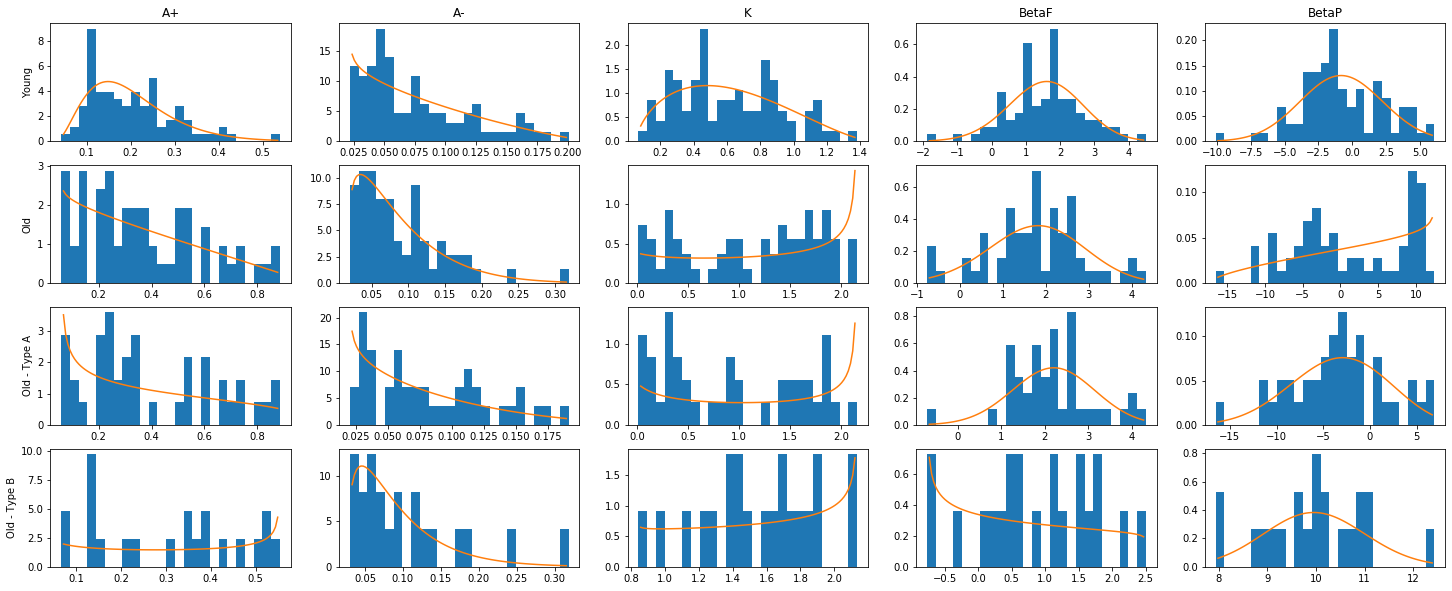

In [16]:
fig, ax = plt.subplots(4, 5, figsize=(25, 10))

# Plots
draw_beta_fit(beta_params_young, df_orl_young, ax[0], "Young")
draw_beta_fit(beta_params_old, df_orl_old, ax[1], "Old")
draw_beta_fit(beta_params_old_a, df_orl_old_a, ax[2], "Old - Type A")
draw_beta_fit(beta_params_old_b, df_orl_old_b, ax[3], "Old - Type B")

# Param titles
for i, param in enumerate(beta_params_young.columns):
    ax[0, i].set_title(param)
    
plt.show()

This lets us compare the parameters across each of the different groups. We can see that the A+ and A- parameters are fairly similar for all of the groups, spread out with a slight skew to the left.  
The K parameter shows a difference between young and old, concentrated centrally versus much more uniform.  
The $\beta_F$ parameter is normally distributed for both the young and old (type A) groups, however with the type B group we see a degredation in the normal shape, being much closer to a uniform distribution. 
Finally the $\beta_P$ parameter clearly shows the three distinct normal distributions. Notably the type B group has much higher values than both the young and type A groups which have similar distributions. In [[1]](http://www.labsi.org/cognitive/Becharaetal1997.pdf), they note that participants with damage to their prefrontal cortex continue to choose bad decks even in the face of punishing outcomes, so this high value of perserverance could be explained by this.  